# Exploring raw data

## Imports and ONE instantiation

In [1]:
import ibldsp.voltage
import ibldsp.cadzow
from neuropixel import split_trace_header
import scipy.signal
import matplotlib.pyplot as plt
from viewephys.gui import viewephys
import numpy as np
from pathlib import Path
import spikeglx

## Download sample data
We have prepared sample data containing a 6 second snippet of the electrophysiology recording for both an NP1 recording and NP2 4 shank recording. 

You can download this data by clicking the [link](https://ibl-brain-wide-map-public.s3.amazonaws.com/index.html#sample_data/cajal) and unzipping the folder on your computer.

Adjust the example paths below to the path of the data on your computer.

In [2]:
np1_data = Path('/Users/admin/Downloads/cajal/np1')
np2_data = Path('/Users/admin/Downloads/cajal/np2')

## Exploring the metadata
To start we can explore the metadata. We will compare the metadata between the AP and LFP bands and the NP1 vs NP2 probes. Note the NP2 data does not contain the data from the LF band.

First load in the data for the AP and LP bands for the NP1 and NP2 probes

In [3]:
sr = {'NP1': {}, 'NP2': {}}

file = next(np1_data.joinpath('raw_ephys_data').glob('*ap*.*bin'))
sr['NP1']['ap'] = spikeglx.Reader(file, ignore_warnings=True)

file = next(np1_data.joinpath('raw_ephys_data').glob('*lf*.*bin'))
sr['NP1']['lf'] = spikeglx.Reader(file)

file = next(np2_data.joinpath('raw_ephys_data').glob('*ap*.*bin'))
sr['NP2']['ap'] = spikeglx.Reader(file)

Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
/Users/admin/Downloads/cajal/np1/raw_ephys_data/_spikeglx_ephysData_g0_t0.imec0.lf.stream.cbin : meta data and compressed chunks dont checkout
File duration: expected 3668.9784, actual 6.0
Will attempt to fudge the meta-data information.
/Users/admin/Downloads/cajal/np2/raw_ephys_data/spikeglx_ephysData_g0_t0.imec0.ap.stream.cbin : meta data and compressed chunks dont checkout
File duration: expected 6387.132633333334, actual 6.0
Will attempt to fudge the meta-data information.


We can compare the sampling rate and the voltage range of the different recordings

In [4]:
print(f"Sampling rate of AP band on NP1: {sr['NP1']['ap'].fs}")
print(f"Sampling rate of LF band on NP1: {sr['NP1']['lf'].fs}")
print(f"Sampling rate of AP band on NP2: {sr['NP2']['ap'].fs}")

# Voltage range
print(f"\nVoltage range of AP band on NP1: {sr['NP1']['ap'].range_volts[0]}")
print(f"Voltage range of LF band on NP1: {sr['NP1']['lf'].range_volts[0]}")
print(f"Voltage range of AP band on NP2: {sr['NP2']['ap'].range_volts[0]}")

Sampling rate of AP band on NP1: 30000.0
Sampling rate of LF band on NP1: 2500.0
Sampling rate of AP band on NP2: 30000.0

Voltage range of AP band on NP1: 0.0012
Voltage range of LF band on NP1: 0.0024
Voltage range of AP band on NP2: 0.0062500000931322575


We can now explore the geometry of the probes

In [5]:
print(f"Number of shanks on NP1: {len(np.unique(sr['NP1']['ap'].geometry['shank']))}")
print(f"Number of shanks on NP2: {len(np.unique(sr['NP2']['ap'].geometry['shank']))}")

Number of shanks on NP1: 1
Number of shanks on NP2: 4


We can plot the geometry for each shank

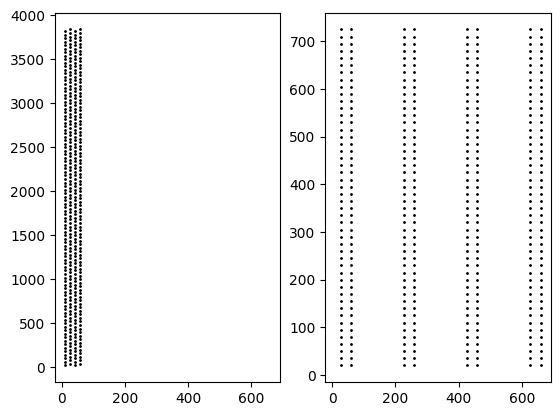

In [6]:
fig, axs = plt.subplots(1, 2, sharey=False, sharex=True)
# For NP1
axs[0].scatter(sr['NP1']['ap'].geometry['x'], sr['NP1']['ap'].geometry['y'], s=1, c='k')
# For NP2
shanks = np.unique(sr['NP2']['ap'].geometry['shank'])
for i, sh in enumerate(shanks):
    geom_sh = split_trace_header(sr['NP2']['ap'].geometry, i)
    axs[1].scatter(geom_sh['x'] + (200 * i), geom_sh['y'], s=1, c='k')

For next two exercises you can choose whether you want to explore the NP1 or NP2 data

In [7]:
version = 'NP1' # 'NP2'
sr_ap = sr[version]['ap']

## Bad channel detection
One critical step before applying any preprocessing to the raw data is to detect bad channels. We detect bad channels on the raw AP band data.

There are 3 ways a channel can be detected as faulty:

*   Dead channel
*   Noisy channel
*   Channel outside of the brain

The following code snippet can be used to detect bad channels. You will see that we pass these channel label assignments into the preprocessing functions that we use below.

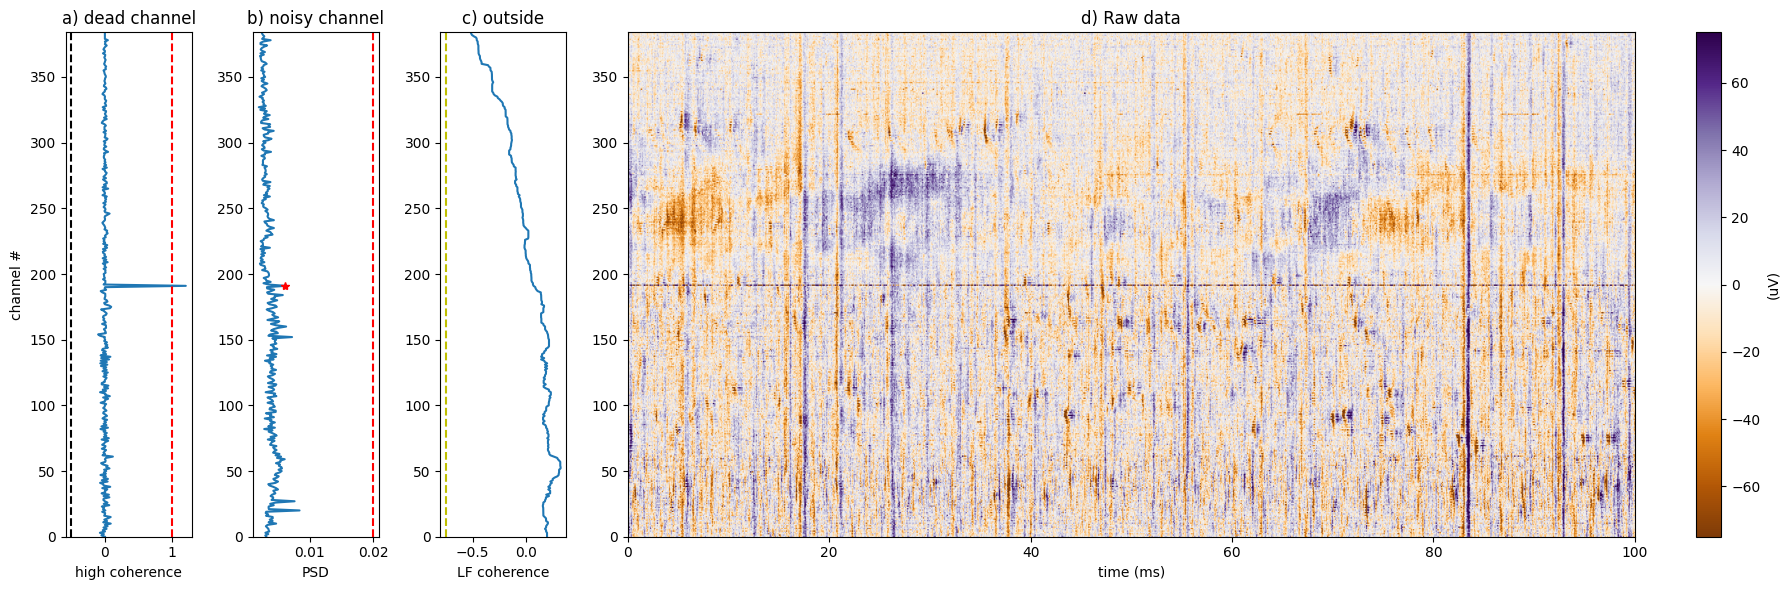

In [8]:
t0 = 1
first, last = (int(t0 * sr_ap.fs), int((t0 + 0.4) * sr_ap.fs))
raw = sr_ap[first:last, :-sr_ap.nsync].T

channel_labels, _ = ibldsp.voltage.detect_bad_channels(raw, fs=sr_ap.fs, display=True)

## Preprocessing AP data and exploring with ViewEphys
Here we provide code to launch the ViewEphys gui and explore the raw ap band data in serveral forms
1. Raw data
2. After applying high pass filter
3. After applying high pass filter and spatial filter (destriping)

In [ ]:
t0 = 1
s0 = int(sr_ap.fs * t0)
int0 = int(0.75 * sr_ap.fs)  # We take 0.75 second after t0
int1 = int(1 * sr_ap.fs)  # Up to 1 second after t0


data_ap = {}
# Raw ap data
data_ap['ap_raw'] = sr_ap[s0 + int0:s0 + int1, :-sr_ap.nsync].T
# High passed ap data
data_ap['ap_highpass'] = scipy.signal.sosfiltfilt(scipy.signal.butter(3, 300, 'hp', fs=sr_ap.fs, output='sos'), data_ap['ap_raw'])
# Destriped ap data
data_ap['ap_destripe'] = ibldsp.voltage.destripe(data_ap['ap_raw'], sr_ap.fs, channel_labels=channel_labels)

# Display ap signal using ViewEphys
evs = {}
for key, val in data_ap.items():
  evs[key] = viewephys(data=val, fs=sr_ap.fs, title=key, channels=sr_ap.geometry, colormap='PuOr')
%gui qt

### Navigation hints

*   Adjust the gain of the display using Control + A or Control + Z
*   Control + P will link the windows and propagate any changes across all displays
*  With the right mouse button pressed you can zoom, with the left button pressed you can pan
*  Change the order in which the channels are sorted by entering a sorting option after `Sort:` (sorting options are given in the dropdown menu)

## Preprocessing LFP data and exploring with ViewEphys

Here we provide code to launch the ViewEphys gui and explore the raw lfp band data in serveral forms. We only have access to the LF data for 
the NP1 probe, so we will explore this dataset. 

1. Raw data
2. After applying high pass filter and spatial filter (destriping)
3. After resampling (decimating)
4. After computing the current source density (CSD)

Note how we use the AP band bad channel assignment for the LFP processing.

We also show an alternative Cadzow filter that can be applied to the signal for an alternative CSD computation 
(this is only relevant for NP1 probes)

In [ ]:
version = 'NP1'
sr_ap = sr[version]['ap']
sr_lf = sr[version]['lf']

# Detect bad channels using AP band
t0 = 1
first, last = (int(t0 * sr_ap.fs), int((t0 + 0.4) * sr_ap.fs))
raw = sr_ap[first:last, :-sr_ap.nsync].T

channel_labels, _ = ibldsp.voltage.detect_bad_channels(raw, fs=sr_ap.fs, display=False)

t0 = 1  # Seconds in the recording
s0 = int(sr_lf.fs * t0)
int0 = int(0.75 * sr_lf.fs)  # We take 0.75 second after t0
int1 = int(3 * sr_lf.fs)  # Up to 3 second after t0

data_lf = {}

# Raw lfp data
data_lf['lf_raw'] = sr_lf[s0 + int0:s0 + int1, :-sr_lf.nsync].T

# Destriped lfp data
data_lf['lf_destripe'] = ibldsp.voltage.destripe_lfp(data_lf['lf_raw'], fs=sr_lf.fs, channel_labels=channel_labels, k_filter=None)

# Resampled lfp data
data_lf['lf_decimate'] = scipy.signal.decimate(data_lf['lf_destripe'], q=5, zero_phase=True)

# Current source density (CSD)
data_lf['lf_csd'] = ibldsp.voltage.current_source_density(data_lf['lf_decimate'], h=sr_lf.geometry)

# Cadzow filter
data_lf['lf_cadzow'] = ibldsp.cadzow.cadzow_np1(data_lf['lf_decimate'], fs=sr_lf.fs / 5, fmax=200, rank=5, h=sr_lf.geometry)

# CSD after cadzow
data_lf['lf_csd_cadzow'] = ibldsp.voltage.current_source_density(data_lf['lf_cadzow'], h=sr_lf.geometry)

# Display the lfp signal in ViewEphys
show_cadzow = False
evs = {}
for key, val in data_lf.items():
  if not show_cadzow:
    if 'cadzow' in key:
      continue
  fs = sr_lf.fs if key in ['lf_raw', 'lf_destripe'] else sr_lf.fs / 5
  evs[key] = viewephys(data=val, fs=fs, title=key, channels=sr_lf.geometry, colormap='PuOr')
%gui qt

## Linking AP and LFP displays
Here we show how to simulatneously display the AP and LFP signals in the ViewEphys gui. You can use ctrl + P to link the displays


In [ ]:
# Load in AP and LFP data of same duration
t0 = 1  # Seconds in the recording
s0 = int(sr_ap.fs * t0)
int0 = int(0.75 * sr_ap.fs)  # We take 0.75 second after t0
int1 = int(1 * sr_ap.fs)  # Up to 1 second after t0
raw_ap = sr_ap[s0 + int0:s0 + int1, :-sr_ap.nsync].T

t0 = 1  # Seconds in the recording
s0 = int(sr_lf.fs * t0)
int0 = int(0.75 * sr_lf.fs)  # We take 0.75 second after t0
int1 = int(1 * sr_lf.fs)  # Up to 1 second after t0
raw_lfp = sr_lf[s0 + int0:s0 + int1, :-sr_ap.nsync].T

data = {}
# Preprocess ap data
data['ap_band'] = ibldsp.voltage.destripe(raw_ap, sr_ap.fs, channel_labels=channel_labels)
# Preprocess lf data
data['lf_band'] = ibldsp.voltage.destripe_lfp(raw_lfp, fs=sr_lf.fs, channel_labels=channel_labels, k_filter=None)

evs = {}
evs['ap_band'] = viewephys(data=data['ap_band'], fs=sr_ap.fs, channels=sr_ap.geometry, title='ap_band', colormap='PuOr')
evs['lf_band'] = viewephys(data=data['lf_band'], fs=sr_lf.fs, channels=sr_lf.geometry, title='lf_band', colormap='PuOr')
%gui qt


## Exploring raw data in various brain regions

In this section we encourage you to explore the data stored in this website. It contains plots of the raw AP data collected from a wide range of brain regions.

http://reveal.internationalbrainlab.org.s3-website-us-east-1.amazonaws.com/benchmarks.html

### Navigation hints

*   Up and down arrows toggle between different displays in a single recording
*   Left and right arrows switch between different recordings
*   Sliders on the raw data display allow you to see the effects of pre-processing on the data